In [1]:
! pip install d2l==0.17.0

In [2]:
!pip install tensorflow==2.8.0

# Concise Implementation of Recurrent Neural Networks
:label:`sec_rnn-concise`

While :numref:`sec_rnn_scratch` was instructive to see how RNNs are implemented,
this is not convenient or fast.
This section will show how to implement the same language model more efficiently
using functions provided by high-level APIs
of a deep learning framework.
We begin as before by reading the time machine dataset.


In [3]:
# Import the TensorFlow library
import tensorflow as tf

# Import the d2l library for TensorFlow, which contains utilities for deep learning
from d2l import tensorflow as d2l

# Define the batch size and the number of time steps
batch_size, num_steps = 32, 35

# Load the dataset using the d2l library's load_data_time_machine function
# This function returns an iterator for the training data and the vocabulary
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## [**Defining the Model**]

High-level APIs provide implementations of recurrent neural networks.
We construct the recurrent neural network layer `rnn_layer` with a single hidden layer and 256 hidden units.
In fact, we have not even discussed yet what it means to have multiple layers---this will happen in :numref:`sec_deep_rnn`.
For now, suffice it to say that multiple layers simply amount to the output of one layer of RNN being used as the input for the next layer of RNN.


In [4]:
# Import the TensorFlow library
import tensorflow as tf

# Define the number of hidden units for the RNN cell
num_hiddens = 256

# Create a SimpleRNNCell with the specified number of hidden units
# The kernel_initializer is set to 'glorot_uniform' for initializing the weights
rnn_cell = tf.keras.layers.SimpleRNNCell(num_hiddens, kernel_initializer='glorot_uniform')

# Create an RNN layer using the RNN cell
# time_major=True indicates that the input tensor's shape is [time_steps, batch_size, num_features]
# return_sequences=True means the RNN layer will return the full sequence of outputs
# return_state=True means the RNN layer will also return the final state
rnn_layer = tf.keras.layers.RNN(rnn_cell, time_major=True, return_sequences=True, return_state=True)

# Define the batch size, number of time steps, and number of features for the input data
batch_size = 32
time_steps = 35
num_features = 100

# Generate a random input tensor with the specified shape
X = tf.random.normal((batch_size, time_steps, num_features))

# Pass the input tensor through the RNN layer
# The output is the sequence of outputs from the RNN layer
# The state is the final state of the RNN layer
output, state = rnn_layer(X)

# Print the shapes of the output and state tensors
print("Output shape:", output.shape)
print("State shape:", state.shape)

Output shape: (32, 35, 256)
State shape: (35, 256)


In [5]:
# Import the TensorFlow library
import tensorflow as tf

# Define the batch size and the number of hidden units for the RNN cell
batch_size = 32
num_hiddens = 256

# Create a SimpleRNNCell with the specified number of hidden units
# The kernel_initializer is set to 'glorot_uniform' for initializing the weights
rnn_cell = tf.keras.layers.SimpleRNNCell(num_hiddens, kernel_initializer='glorot_uniform')

# Get the initial state for the RNN cell
# The initial state is a tensor of zeros with shape [batch_size, num_hiddens]
state = rnn_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)

# Print the shape of the initial state tensor
state.shape

TensorShape([32, 256])

[**With a hidden state and an input,
we can compute the output with
the updated hidden state.**]
It should be emphasized that
the "output" (`Y`) of `rnn_layer`
does *not* involve computation of output layers:
it refers to
the hidden state at *each* time step,
and they can be used as the input
to the subsequent output layer.


In [6]:
# Import the TensorFlow library
import tensorflow as tf

# Parameters
num_steps = 35  # Number of time steps
batch_size = 32  # Batch size
num_hiddens = 256  # Number of hidden units in the RNN cell
vocab_size = len(vocab)  # Size of the vocabulary

# Create a SimpleRNNCell with the specified number of hidden units
# The kernel_initializer is set to 'glorot_uniform' for initializing the weights
rnn_cell = tf.keras.layers.SimpleRNNCell(num_hiddens, kernel_initializer='glorot_uniform')

# Create an RNN layer using the RNN cell
# time_major=True indicates that the input tensor's shape is [time_steps, batch_size, num_features]
# return_sequences=True means the RNN layer will return the full sequence of outputs
# return_state=True means the RNN layer will also return the final state
rnn_layer = tf.keras.layers.RNN(rnn_cell, time_major=True, return_sequences=True, return_state=True)

# Get the initial state for the RNN cell
# The initial state is a tensor of zeros with shape [batch_size, num_hiddens]
state = rnn_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)

# Generate a random input tensor with the shape [num_steps, batch_size, vocab_size]
X = tf.random.uniform((num_steps, batch_size, vocab_size))

# Pass the input tensor and the initial state through the RNN layer
# Y is the sequence of outputs from the RNN layer
# state_new is the final state of the RNN layer
Y, state_new = rnn_layer(X, state)

# Print the shapes of the output tensor and the final state tensor
Y.shape, len(state_new), state_new[0].shape

(TensorShape([35, 32, 256]), 32, TensorShape([256]))

Similar to :numref:`sec_rnn_scratch`,
[**we define an `RNNModel` class
for a complete RNN model.**]
Note that `rnn_layer` only contains the hidden recurrent layers, we need to create a separate output layer.


In [7]:
# Define a custom RNN model by subclassing tf.keras.layers.Layer
class RNNModel(tf.keras.layers.Layer):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        # Call the parent class's initializer
        super(RNNModel, self).__init__(**kwargs)
        # Store the RNN layer and vocabulary size
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        # Define a dense layer to map the RNN outputs to the vocabulary size
        self.dense = tf.keras.layers.Dense(vocab_size)

    # Define the forward pass of the model
    def call(self, inputs, state):
        # Convert inputs to one-hot encoding and transpose to match RNN input shape
        X = tf.one_hot(tf.transpose(inputs), self.vocab_size)
        # Pass the one-hot encoded inputs and initial state through the RNN layer
        Y, *state = self.rnn(X, state)
        # Reshape the RNN outputs and pass them through the dense layer
        output = self.dense(tf.reshape(Y, (-1, Y.shape[-1])))
        # Return the output and the new state
        return output, state

    # Define a method to get the initial state of the RNN
    def begin_state(self, *args, **kwargs):
        # Use the RNN cell's method to get the initial state
        return self.rnn.cell.get_initial_state(*args, **kwargs)

## Training and Predicting

Before training the model, let us [**make a prediction with the a model that has random weights.**]


In [8]:
# Get the name of the GPU device if available, otherwise fallback to CPU
device_name = d2l.try_gpu()._device_name

# Create a distribution strategy for a single device (GPU or CPU)
strategy = tf.distribute.OneDeviceStrategy(device_name)

# Use the distribution strategy's scope to create and initialize the model
with strategy.scope():
    # Instantiate the RNNModel with the specified RNN layer and vocabulary size
    net = RNNModel(rnn_layer, vocab_size=len(vocab))

# Use the d2l library's predict_ch8 function to generate predictions
# 'time traveller' is the initial input text, 10 is the number of characters to predict
# net is the RNN model, and vocab is the vocabulary
d2l.predict_ch8('time traveller', 10, net, vocab)

'time travellerzmo <unk>cekdz'

As is quite obvious, this model does not work at all. Next, we call `train_ch8` with the same hyperparameters defined in :numref:`sec_rnn_scratch` and [**train our model with high-level APIs**].


perplexity 1.3, 12369.4 tokens/sec on /CPU:0
time traveller het enimenslarsel ithry sheor an ansuat dithes oo
traveller authonest enactima an aullaywou speerat li he for


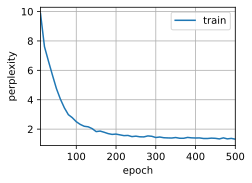

In [9]:
# Define the number of epochs and the learning rate for training
num_epochs, lr = 500, 1

# Train the model using the d2l library's train_ch8 function
# net is the RNN model, train_iter is the training data iterator, vocab is the vocabulary
# lr is the learning rate, num_epochs is the number of epochs to train for
# strategy is the distribution strategy for training on a specific device (GPU or CPU)
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, strategy)

Compared with the last section, this model achieves comparable perplexity,
albeit within a shorter period of time, due to the code being more optimized by
high-level APIs of the deep learning framework.


## Summary

* High-level APIs of the deep learning framework provides an implementation of the RNN layer.
* The RNN layer of high-level APIs returns an output and an updated hidden state, where the output does not involve output layer computation.
* Using high-level APIs leads to faster RNN training than using its implementation from scratch.

## Exercises

1. Can you make the RNN model overfit using the high-level APIs?
1. What happens if you increase the number of hidden layers in the RNN model? Can you make the model work?
1. Implement the autoregressive model of :numref:`sec_sequence` using an RNN.


[Discussions](https://discuss.d2l.ai/t/2211)


## 1. Can you make the RNN model overfit using the high-level APIs?

In [10]:
import tensorflow as tf
from d2l import tensorflow as d2l
import matplotlib.pyplot as plt

# Load data
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [11]:
# Use a smaller subset of the dataset to increase the likelihood of overfitting
small_train_iter = []
small_val_iter = []
for i, (X, Y) in enumerate(train_iter):
    if i < 5:  # Use the first 10 batches for training
        small_train_iter.append((X, Y))
    elif i < 9:  # Use the next 10 batches for validation
        small_val_iter.append((X, Y))
    else:
        break

In [12]:
# Debugging: Print the sizes of the training and validation datasets
print(f"Training dataset size: {len(small_train_iter)}")
print(f"Validation dataset size: {len(small_val_iter)}")

Training dataset size: 5
Validation dataset size: 3


In [13]:
# Define model parameters
num_hiddens = 512  # Increase the number of hidden units
vocab_size = len(vocab)
num_layers = 3  # Number of hidden layers

In [14]:
# Define the RNN model using the functional API
inputs = tf.keras.Input(shape=(num_steps,))
x = tf.keras.layers.Embedding(vocab_size, num_hiddens)(inputs)

# Add multiple RNN layers
for _ in range(num_layers):
    x = tf.keras.layers.SimpleRNN(num_hiddens, return_sequences=True)(x)

outputs = tf.keras.layers.Dense(vocab_size)(x)

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])


In [15]:
# Prepare the dataset for training and validation
def preprocess(data_iter):
    for X, Y in data_iter:
        yield X, tf.reshape(Y, (batch_size, num_steps))

train_dataset = tf.data.Dataset.from_generator(
    lambda: preprocess(small_train_iter),
    output_signature=(
        tf.TensorSpec(shape=(batch_size, num_steps), dtype=tf.int32),
        tf.TensorSpec(shape=(batch_size, num_steps), dtype=tf.int32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: preprocess(small_val_iter),
    output_signature=(
        tf.TensorSpec(shape=(batch_size, num_steps), dtype=tf.int32),
        tf.TensorSpec(shape=(batch_size, num_steps), dtype=tf.int32)
    )
)

In [16]:
# Debugging: Print the first batch of the training and validation datasets
for X, Y in train_dataset.take(1):
    print(f"Training batch X shape: {X.shape}, Y shape: {Y.shape}")

for X, Y in val_dataset.take(1):
    print(f"Validation batch X shape: {X.shape}, Y shape: {Y.shape}")

# Train the model
history = model.fit(train_dataset, epochs=100, validation_data=val_dataset)

Training batch X shape: (32, 35), Y shape: (32, 35)
Validation batch X shape: (32, 35), Y shape: (32, 35)
Epoch 1/100
5/5 [==============================] - 4s 456ms/step - loss: 3.5926 - accuracy: 0.0930 - val_loss: 3.3940 - val_accuracy: 0.1116
Epoch 2/100
5/5 [==============================] - 1s 245ms/step - loss: 3.1349 - accuracy: 0.1457 - val_loss: 2.9279 - val_accuracy: 0.1741
Epoch 3/100
5/5 [==============================] - 1s 237ms/step - loss: 2.9142 - accuracy: 0.1736 - val_loss: 2.8750 - val_accuracy: 0.1747
Epoch 4/100
5/5 [==============================] - 1s 243ms/step - loss: 2.8849 - accuracy: 0.1746 - val_loss: 2.8552 - val_accuracy: 0.1738
Epoch 5/100
5/5 [==============================] - 1s 238ms/step - loss: 2.8686 - accuracy: 0.1741 - val_loss: 2.8582 - val_accuracy: 0.1744
Epoch 6/100
5/5 [==============================] - 1s 249ms/step - loss: 2.8593 - accuracy: 0.1748 - val_loss: 2.8531 - val_accuracy: 0.1741
Epoch 7/100
5/5 [==============================]

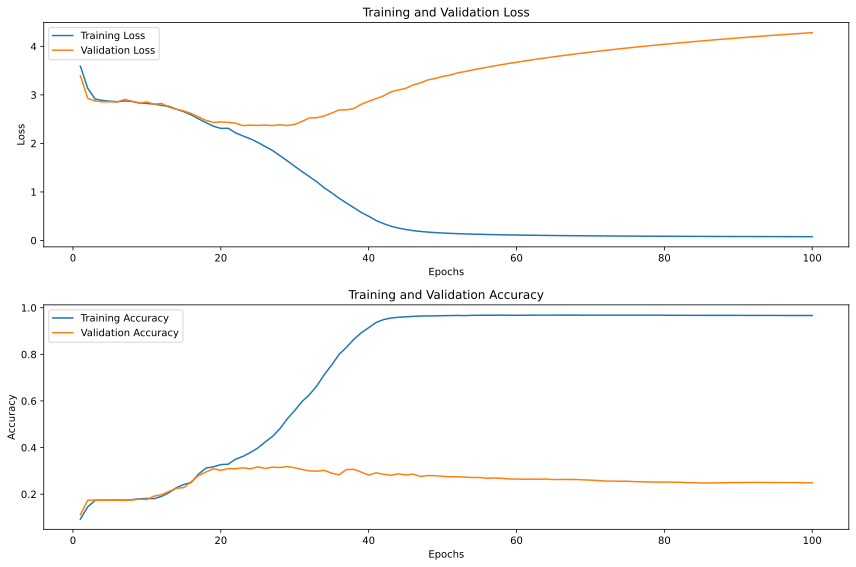

In [17]:
# Plot the training and validation loss and accuracy
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
train_acc = history.history['accuracy']

# Check if validation metrics are available
val_loss = history.history.get('val_loss', [])
val_acc = history.history.get('val_accuracy', [])

plt.figure(figsize=(12, 8))

# Plot training and validation loss
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss, label='Training Loss')
if val_loss:
    plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
if val_acc:
    plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 2. What happens if you increase the number of hidden layers in the RNN model? Can you make the model work?

In [18]:
import tensorflow as tf
from d2l import tensorflow as d2l
import matplotlib.pyplot as plt

# Load data
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [19]:
# Split the dataset into training and validation sets
train_data = []
val_data = []
for i, (X, Y) in enumerate(train_iter):
    if i > 4:  # Use every 10th batch for validation
        val_data.append((X, Y))
    else:
        train_data.append((X, Y))

In [20]:
# Debugging: Print the sizes of the training and validation datasets
print(f"Training dataset size: {len(train_data)}")
print(f"Validation dataset size: {len(val_data)}")

Training dataset size: 5
Validation dataset size: 3


In [21]:
# Define model parameters
num_hiddens = 256
vocab_size = len(vocab)
num_layers = 3  # Number of hidden layers
dropout_rate = 0.5  # Dropout rate

# Define the RNN model with multiple hidden layers using high-level APIs
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, num_hiddens))

# Add multiple RNN layers with dropout
for _ in range(num_layers):
    model.add(tf.keras.layers.SimpleRNN(num_hiddens, return_sequences=True))
    model.add(tf.keras.layers.Dropout(dropout_rate))

# Add the final dense layer
model.add(tf.keras.layers.Dense(vocab_size))

In [22]:
# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])

# Prepare the dataset for training and validation
def preprocess(data_iter):
    for X, Y in data_iter:
        yield X, tf.reshape(Y, (batch_size, num_steps))

train_dataset = tf.data.Dataset.from_generator(
    lambda: preprocess(train_data),
    output_signature=(
        tf.TensorSpec(shape=(batch_size, num_steps), dtype=tf.int32),
        tf.TensorSpec(shape=(batch_size, num_steps), dtype=tf.int32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: preprocess(val_data),
    output_signature=(
        tf.TensorSpec(shape=(batch_size, num_steps), dtype=tf.int32),
        tf.TensorSpec(shape=(batch_size, num_steps), dtype=tf.int32)
    )
)

# Use early stopping to stop training when the validation loss stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [23]:
# Train the model
history = model.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/100
5/5 [==============================] - 3s 196ms/step - loss: 3.4495 - accuracy: 0.0846 - val_loss: 2.9999 - val_accuracy: 0.1735
Epoch 2/100
5/5 [==============================] - 1s 112ms/step - loss: 3.2613 - accuracy: 0.1123 - val_loss: 2.9134 - val_accuracy: 0.1777
Epoch 3/100
5/5 [==============================] - 1s 105ms/step - loss: 3.1519 - accuracy: 0.1246 - val_loss: 2.9385 - val_accuracy: 0.1771
Epoch 4/100
5/5 [==============================] - 0s 103ms/step - loss: 3.0687 - accuracy: 0.1464 - val_loss: 2.8877 - val_accuracy: 0.1762
Epoch 5/100
5/5 [==============================] - 0s 100ms/step - loss: 3.0206 - accuracy: 0.1538 - val_loss: 2.8985 - val_accuracy: 0.1830
Epoch 6/100
5/5 [==============================] - 1s 105ms/step - loss: 2.9656 - accuracy: 0.1652 - val_loss: 2.8673 - val_accuracy: 0.1792
Epoch 7/100
5/5 [==============================] - 1s 109ms/step - loss: 2.9065 - accuracy: 0.1802 - val_loss: 2.8673 - val_accuracy: 0.1923
Epoch 8/100
5

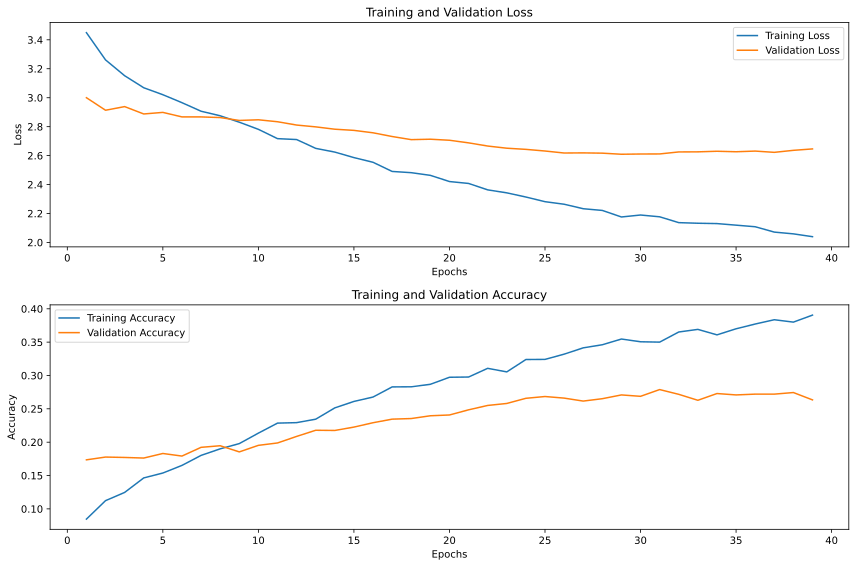

In [24]:
# Plot the training and validation loss and accuracy
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
train_acc = history.history['accuracy']

# Check if validation metrics are available
val_loss = history.history.get('val_loss', [])
val_acc = history.history.get('val_accuracy', [])

plt.figure(figsize=(12, 8))

# Plot training and validation loss
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss, label='Training Loss')
if val_loss:
    plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
if val_acc:
    plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()